# 3 - Régression linéaire

L'objectif de ce notebook est d'effectuer quelques analyses et tests statistiques afin de déterminer "à la main" quelle variables/combinaisons de variables expliquent le montant du pourboire.

## Import et préparation du dataset

Importons les librairies que nous utiliserons :

In [1]:
%matplotlib inline
import os
#os.chdir('/Users/pierredesmet/Documents/Documents Word/Etudes/UTT/ENSAE/Python pour le Data Scientist')
os.chdir('C:\\Users\\Alexis\\Google Drive\\Documents\\ENSAE\\Semestre 1\\Projet python\\')
import pandas
import statsmodels
import statsmodels.api as sm
import seaborn
import matplotlib.pyplot as plt
import numpy
import importation

On charge les données :

In [2]:
trips = importation.chargement_donnees()
trips = importation.clean(trips)

Nous souhaitons effectuer des régressions linéaires. Il faut donc convertir les variables catégorielles (ie. `vendor_id`, `payment_type`, `nuit_jour` et `jour_semaine`) en variables binaires :

In [3]:
trips = pandas.get_dummies(data=trips, columns=['nuit_jour', 'jour_semaine', 'vendor_id', 'payment_type'])    

Vérifions que les variables catégorielles ont bien été converties :

In [4]:
trips.head()

,medallion,hack_license,pickup_datetime,fare_amount,surcharge,tip_amount,tolls_amount,total_amount,dropoff_datetime,passenger_count,...,jour_semaine_Thursday,jour_semaine_Tuesday,jour_semaine_Wednesday,vendor_id_CMT,vendor_id_VTS,payment_type_CRD,payment_type_CSH,payment_type_DIS,payment_type_NOC,payment_type_UNK
0,D5367E940A20B9D2550BF7CF7AE01681,5B34A2589D1D2106FC0C47564A4833F0,2013-01-08 12:50:22,7.5,0.0,0.0,0.0,8.0,2013-01-08 12:58:39,2,...,0,1,0,1,0,0,1,0,0,0
1,69F42CD1BA72F0F090E85F299C7B6301,65BABDDBC94F4C1AA996FA693E4D4F57,2013-01-13 11:09:00,5.0,0.0,1.0,0.0,6.5,2013-01-13 11:13:00,1,...,0,0,0,0,1,1,0,0,0,0
2,F0C1205FC27DF89D8C9F8DC2F324E36C,FAA39BEB7D7159DCB3DCAC56EED0CEA7,2013-01-13 10:28:00,4.5,0.0,0.0,0.0,5.0,2013-01-13 10:31:00,5,...,0,0,0,0,1,0,1,0,0,0
3,3112FC4E5C14054B8A5DB00037572C70,9F959826431402B410E0B8FA23160AFE,2013-01-13 10:32:00,5.5,0.0,0.0,0.0,6.0,2013-01-13 10:35:00,5,...,0,0,0,0,1,0,1,0,0,0
5,C852FCF8AFF847126AF8A109DE44BB1F,DFF8F13106E8C8C3773DE379678334E3,2013-01-13 06:28:00,8.0,0.0,0.0,0.0,8.5,2013-01-13 06:36:00,1,...,0,0,0,0,1,0,1,0,0,0


## Matrice des corrélations
Calculons la matrice des corrélations afin d'avoir une vue d'ensemble sur les variables qui semblent "proches".

In [5]:
corr_mat = trips.drop(['medallion', 'hack_license', 'pickup_datetime', 'dropoff_datetime'], axis=1).corr()
corr_mat

,fare_amount,surcharge,tip_amount,tolls_amount,total_amount,passenger_count,trip_time_in_secs,trip_distance,pickup_longitude,pickup_lattitude,...,jour_semaine_Thursday,jour_semaine_Tuesday,jour_semaine_Wednesday,vendor_id_CMT,vendor_id_VTS,payment_type_CRD,payment_type_CSH,payment_type_DIS,payment_type_NOC,payment_type_UNK
fare_amount,1.000000,-0.006912,0.489083,0.509303,0.974903,0.012521,0.888258,0.918313,0.321182,-0.015437,...,0.013715,-0.004508,0.005550,-0.009097,0.009097,0.106680,-0.107277,0.002224,0.001191,0.005315
surcharge,-0.006912,1.000000,0.028744,-0.018783,0.048341,0.012415,-0.024415,0.023543,-0.038647,-0.066744,...,0.049546,0.044917,0.049316,-0.008094,0.008094,0.023035,-0.023373,0.002362,0.004089,-0.001331
tip_amount,0.489083,0.028744,1.000000,0.331637,0.648434,-0.012727,0.410075,0.472128,0.178125,-0.026681,...,0.018087,0.008012,0.017307,0.001545,-0.001545,0.683092,-0.681905,-0.016013,-0.028185,0.020092
tolls_amount,0.509303,-0.018783,0.331637,1.000000,0.593267,0.007309,0.306219,0.565129,0.470642,0.094948,...,0.005976,0.002853,0.002351,-0.006807,0.006807,0.047135,-0.047501,0.003438,0.001458,0.001191
total_amount,0.974903,0.048341,0.648434,0.593267,1.000000,0.008953,0.844153,0.912193,0.348943,-0.011333,...,0.018144,0.000569,0.010920,-0.008272,0.008272,0.237998,-0.238298,-0.001103,-0.004662,0.008812
passenger_count,0.012521,0.012415,-0.012727,0.007309,0.008953,1.000000,0.012714,0.016399,-0.001543,-0.006460,...,-0.009403,-0.007542,-0.010870,-0.311188,0.311188,-0.018285,0.018766,-0.006142,-0.011736,0.010360
trip_time_in_secs,0.888258,-0.024415,0.410075,0.306219,0.844153,0.012714,1.000000,0.712622,0.181536,-0.016721,...,0.033416,0.006967,0.025328,-0.008445,0.008445,0.092673,-0.092807,0.000959,-0.005159,0.006573
trip_distance,0.918313,0.023543,0.472128,0.565129,0.912193,0.016399,0.712622,1.000000,0.367119,-0.016867,...,-0.005076,-0.013722,-0.011942,-0.011269,0.011269,0.105297,-0.105342,0.000245,-0.003673,0.003936
pickup_longitude,0.321182,-0.038647,0.178125,0.470642,0.348943,-0.001543,0.181536,0.367119,1.000000,0.497779,...,0.004832,0.010480,0.005414,-0.009025,0.009025,-0.014377,0.013965,0.002500,0.000579,0.003934
pickup_lattitude,-0.015437,-0.066744,-0.026681,0.094948,-0.011333,-0.006460,-0.016721,-0.016867,0.497779,1.000000,...,0.013014,0.028328,0.020340,-0.003787,0.003787,-0.060028,0.060043,0.000065,-0.001265,0.001600


Affichons-là graphiquement avec seaborn :

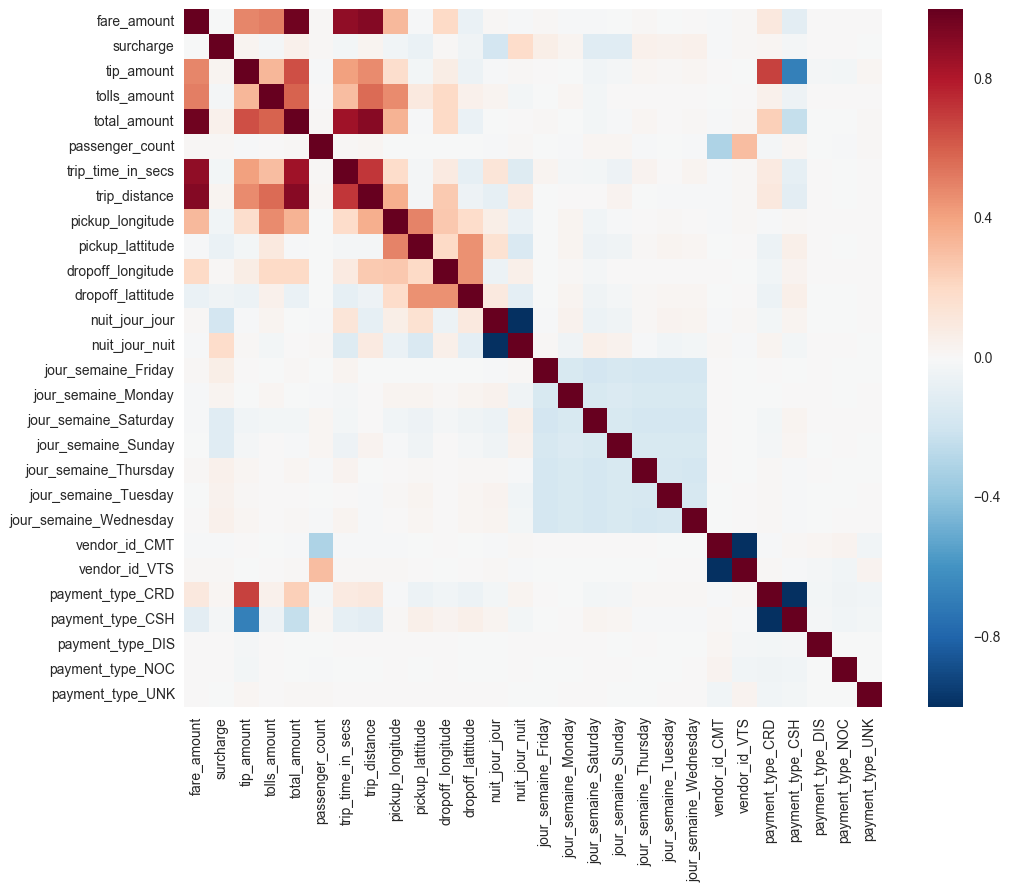

In [6]:
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(12, 9))

# Draw the heatmap using seaborn
seaborn.heatmap(corr_mat, vmax=.8, square=True)

On peut faire plusieurs remarques : 
- les variables catégorielles forment des 'blocs' entre elles : cela est normal (jour=1 => nuit=0 par exemple) ;
- les tips sont fortement corrélés avec les paiements par carte et corrélés négativement avec les paiements en espèces : effectivement, le descriptif des données mentionne 
    > 'Cash tips are not included'.
- les corrélations ont l'air vraisemblables : `trip_fare` est corrélé positivement avec `trip_time_in_secs`, `trip_distance`, etc.

À partir de maintenant, nous chercherons à déterminer les facteurs pouvant influencer la quantité de pourboire laissé au chauffeur en fin de course.

## Influence des variables sur le montant du pourboire
Calculons tout d'abord des statistiques de base associées à la variable `tip_amount`.

In [7]:
trips['tip_amount'].describe()

count    725673.000000
mean          1.143371
std           1.547079
min           0.000000
25%           0.000000
50%           1.000000
75%           1.900000
max          70.000000
Name: tip_amount, dtype: float64

En moyenne, les gens donnent 1.14$ de pourboire. Nous nous intéresserons donc non pas à la colonne `tip_amount` mais à une nouvelle, `tip_difference`, qui sera la même colonne mais centrée par rapport à sa moyenne. Ainsi, nous observerons les variables qui augmentent ou au contraire diminuent la valeur du pourboire laissé en fin de course.

In [8]:
trips['difference_tip'] = trips['tip_amount'] - trips['tip_amount'].mean()

Effectuons une régression linéaire de cette variable sur les toutes les autres dans un premier temps.

In [9]:
exogene = sm.add_constant(trips[['fare_amount', 'surcharge', 'tolls_amount', 'passenger_count', 'trip_distance',
                                              'trip_time_in_secs', 'nuit_jour_jour', 'nuit_jour_nuit', 'vendor_id_CMT',
                                              'vendor_id_VTS', 'jour_semaine_Monday', 'jour_semaine_Tuesday',
                                              'jour_semaine_Wednesday', 'jour_semaine_Thursday', 'jour_semaine_Friday',
                                              'jour_semaine_Saturday', 'jour_semaine_Sunday'
                                              ]])

model = sm.OLS(endog=trips['difference_tip'], exog=exogene)
resultats = model.fit()
resultats.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         difference_tip   R-squared:                       0.252
Model:                            OLS   Adj. R-squared:                  0.252
Method:                 Least Squares   F-statistic:                 1.744e+04
Date:                Sat, 03 Dec 2016   Prob (F-statistic):               0.00
Time:                        22:11:12   Log-Likelihood:            -1.2411e+06
No. Observations:              725673   AIC:                         2.482e+06
Df Residuals:                  725658   BIC:                         2.482e+06
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------------
const                     -0.5310      0.002   -235.520      0.000        -0.535    -0.527
fare_amount                0.0970      0.001     76.854      0.000         0.095     0.099
surcharge                  0.1046      0.004     23.308      0.000         0.096     0.113
tolls_amount               0.1953      0.003     77.108      0.000         0.190     0.200
passenger_count           -0.0208      0.001    -17.266      0.000        -0.023    -0.018
trip_distance              0.0627      0.003     24.692      0.000         0.058     0.068
trip_time_in_secs      -3.037e-05   9.97e-06     -3.047      0.002     -4.99e-05 -1.08e-05
nuit_jour_jour            -0.2775      0.002   -142.083      0.000        -0.281    -0.274
nuit_jour_nuit            -0.2535      0.002   -112.601      0.000        -0.258    -0.249
vendor_id_CMT             -0.2640      0.002   -141.204      0.000        -0.268    -0.260
vendor_id_VTS             -0.2670      0.002   -125.659      0.000        -0.271    -0.263
jour_semaine_Monday       -0.0698      0.004    -17.215      0.000        -0.078    -0.062
jour_semaine_Tuesday      -0.0391      0.004    -10.081      0.000        -0.047    -0.031
jour_semaine_Wednesday    -0.0195      0.004     -5.071      0.000        -0.027    -0.012
jour_semaine_Thursday     -0.0320      0.004     -8.378      0.000        -0.040    -0.025
jour_semaine_Friday       -0.0770      0.004    -20.406      0.000        -0.084    -0.070
jour_semaine_Saturday     -0.1552      0.004    -40.910      0.000        -0.163    -0.148
jour_semaine_Sunday       -0.1382      0.004    -33.883      0.000        -0.146    -0.130
==============================================================================
Omnibus:                   477848.386   Durbin-Watson:                   1.487
Prob(Omnibus):                  0.000   Jarque-Bera (JB):        138152557.178
Skew:                           2.043   Prob(JB):                         0.00
Kurtosis:                      70.471   Cond. No.                     1.51e+18
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 2.07e-25. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

**Remarque** : on a bien 17 variables mais 14 degrés de liberté du fait de la présence de 'dummy variables'.

Les résidus semblent non corrélés (Durbin-Watson de 1.49). Vérifions-le à l'aide d'une représentation graphique :

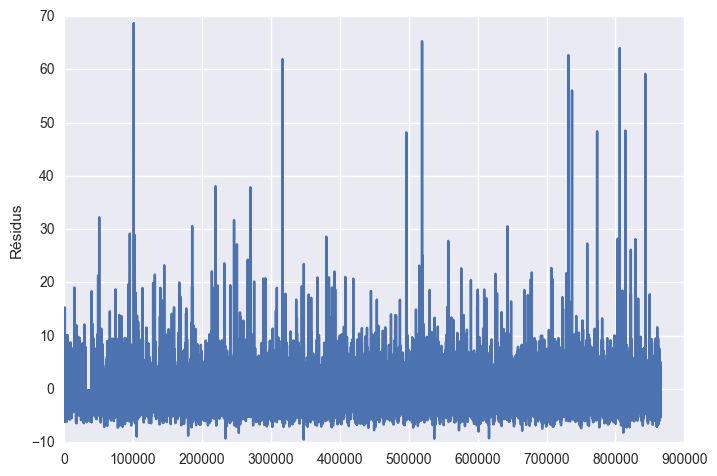

In [10]:
plt.plot(resultats.resid)
plt.ylabel('Résidus')
plt.show()

Les principales conclusions que l'on tire de la précédente régression sont les suivantes :
- la durée de la course a un léger impact positif
- plus la course était chère (péage, distance, surplus), plus le chauffeur peut espérer un pourboire important. Pour les courses qui n'ont pas coûtées cher, les gens ont tendance à ne pas laisser de pourboire quand il est trop petit. En effet, aux Etats-Unis, il est d'usage de laisser environ 10% du prix.  
- plus il y a de passagers, moins le chauffeur a de chance d'obtenir un pourboire. On peut expliquer ceci en supposant que personne dans un groupe ne se "dévoue" pour donner le pourboire, ou bien aussi que celui qui paie pourrait en donner s'il était seul mais refuse de "payer le pourboire des autres"...

Pour les variables catégorielles, testons les quatre hypothèses suivantes :
1. que les deux applications de paiement n'induisent pas de différence sur le pourboire
2. que, le jour et la nuit, les valeurs des pourboires sont différentes (plus élevées le jour par exemple ?)
3. que les jours de semaine rapportent plus de pourboire que les jours de week-end
4. que la vitesse moyenne influence positivement le montant du pourboire laissé au chauffeur

### Hypothèse 1 : les applications de paiement n'influence pas le montant du pourboire

In [11]:
B = numpy.array([0,0,0,0,0,0,0,0,0,1,-1,0,0,0,0,0,0,0])
print(resultats.f_test(B))

<F test: F=array([[ 0.80297022]]), p=0.3702071004150058, df_denom=725658, df_num=1>


On rejette donc l'hypothèse que les deux applications de paiements induisent une différence de pouboire. Une hypothèse pour expliquer ceci est que le choix de l'application se fait de façon aléatoire par rapport aux variables présentes ici.

### Hypothèse 2 : le facteur jour-nuit induit des différences sur le montant du pourboire

In [12]:
B = numpy.array([0,0,0,0,0,0,0,1,-1,0,0,0,0,0,0,0,0,0])
print(resultats.f_test(B))

<F test: F=array([[ 45.54256413]]), p=1.4946902256319645e-11, df_denom=725658, df_num=1>


On ne rejette pas l'hypothèse que `jour_nuit` a une influence sur le pourboire. On conclue ici que les chauffeurs ont plus de pourboire la nuit qu'en journée. Une explication possible serait qu'en journée, les courses sont effectuées pour des hommes/femmes d'affaires, alors que la nuit voit une population plus jeune (p. ex. étudiante).

### Hypothèse 3 : le week-end rapporte moins de pourboire qu'en semaine
Pour tester la dernière hypothèse, il faut transformer légèrement nos variables : regroupons les colonnes correspondant à un jour de semaine dans une colonne, et les jours de week-end dans une autre.

In [13]:
trips['jour_de_semaine'] = trips['jour_semaine_Monday']+trips['jour_semaine_Tuesday']+trips['jour_semaine_Wednesday']+trips['jour_semaine_Thursday']+trips['jour_semaine_Friday']
trips['week_end'] = trips['jour_semaine_Saturday']+trips['jour_semaine_Sunday']

exogene = sm.add_constant(trips[['fare_amount', 'surcharge', 'tolls_amount', 'passenger_count', 'trip_distance',
                                              'trip_time_in_secs', 'nuit_jour_jour', 'nuit_jour_nuit', 'vendor_id_CMT',
                                              'vendor_id_VTS', 'jour_de_semaine', 'week_end'
                                              ]])

model = statsmodels.api.OLS(endog=trips['difference_tip'], exog=exogene)
resultats = model.fit()
resultats.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         difference_tip   R-squared:                       0.252
Model:                            OLS   Adj. R-squared:                  0.252
Method:                 Least Squares   F-statistic:                 2.711e+04
Date:                Sat, 03 Dec 2016   Prob (F-statistic):               0.00
Time:                        22:15:28   Log-Likelihood:            -1.2412e+06
No. Observations:              725673   AIC:                         2.482e+06
Df Residuals:                  725663   BIC:                         2.483e+06
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------------
const                -0.4638      0.002   -239.658      0.000        -0.468    -0.460
fare_amount           0.0971      0.001     76.885      0.000         0.095     0.100
surcharge             0.1046      0.004     23.308      0.000         0.096     0.113
tolls_amount          0.1955      0.003     77.166      0.000         0.191     0.200
passenger_count      -0.0209      0.001    -17.349      0.000        -0.023    -0.019
trip_distance         0.0623      0.003     24.581      0.000         0.057     0.067
trip_time_in_secs -2.951e-05   9.95e-06     -2.964      0.003      -4.9e-05    -1e-05
nuit_jour_jour       -0.2438      0.002   -128.493      0.000        -0.247    -0.240
nuit_jour_nuit       -0.2200      0.002   -102.684      0.000        -0.224    -0.216
vendor_id_CMT        -0.2305      0.002   -128.299      0.000        -0.234    -0.227
vendor_id_VTS        -0.2333      0.002   -115.019      0.000        -0.237    -0.229
jour_de_semaine      -0.1819      0.002    -92.326      0.000        -0.186    -0.178
week_end             -0.2819      0.002   -132.882      0.000        -0.286    -0.278
==============================================================================
Omnibus:                   477595.803   Durbin-Watson:                   1.487
Prob(Omnibus):                  0.000   Jarque-Bera (JB):        137836748.892
Skew:                           2.042   Prob(JB):                         0.00
Kurtosis:                      70.394   Cond. No.                     1.57e+18
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.91e-25. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [14]:
B = numpy.array([0,0,0,0,0,0,0,0,0,0,0,1,-1])
print(resultats.f_test(B))

<F test: F=array([[ 768.58690624]]), p=4.4725573530546114e-169, df_denom=725663, df_num=1>


La p-value est très petite. On en déduit que les chauffeurs recoivent plus de pourboire en semaine qu'en week-end. Cette observation serait cohérente avec la précédente : la semaine les hommes/femmes d'affaires travaillent, le week-end les gens sortent et ont déjà dépensé leur argent...

### Hypothèse 4 : la vitesse de la course influence le montant du pourboire
Testons une dernière hypothèse : la vitesse moyenne de la course influe sur le pourboire. Concrètement, on s'attend à ce qu'une course rapide entraine une satisfaction du client (gain de temps + facture pas trop importante), qui va donc laisser un pourboire. À l'inverse, une course qui aura trainé à cause de bouchons, d'un détour, etc. frustrera le client.

Vérifions le.

In [15]:
trips['vitesse_moyenne'] = trips['trip_distance']/trips['trip_time_in_secs']

exogene = sm.add_constant(trips[['fare_amount', 'surcharge', 'tolls_amount', 'passenger_count', 'vitesse_moyenne',
                                 'nuit_jour_jour', 'nuit_jour_nuit', 'vendor_id_CMT',
                                 'vendor_id_VTS', 'jour_de_semaine', 'week_end']])

model = statsmodels.api.OLS(endog=trips['tip_amount'], exog=exogene)
resultats = model.fit()
resultats.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             tip_amount   R-squared:                       0.251
Model:                            OLS   Adj. R-squared:                  0.251
Method:                 Least Squares   F-statistic:                 3.036e+04
Date:                Sat, 03 Dec 2016   Prob (F-statistic):               0.00
Time:                        22:15:57   Log-Likelihood:            -1.2416e+06
No. Observations:              725673   AIC:                         2.483e+06
Df Residuals:                  725664   BIC:                         2.483e+06
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [95.0% Conf. Int.]
-----------------------------------------------------------------------------------
const              -0.0217      0.002    -12.590      0.000        -0.025    -0.018
fare_amount         0.1121      0.000    365.885      0.000         0.111     0.113
surcharge           0.1122      0.004     25.038      0.000         0.103     0.121
tolls_amount        0.2193      0.002     94.715      0.000         0.215     0.224
passenger_count    -0.0208      0.001    -17.268      0.000        -0.023    -0.018
vitesse_moyenne     0.4691      0.070      6.692      0.000         0.332     0.606
nuit_jour_jour     -0.0357      0.002    -20.258      0.000        -0.039    -0.032
nuit_jour_nuit      0.0140      0.002      6.859      0.000         0.010     0.018
vendor_id_CMT      -0.0099      0.002     -5.704      0.000        -0.013    -0.007
vendor_id_VTS      -0.0118      0.002     -5.950      0.000        -0.016    -0.008
jour_de_semaine     0.0336      0.002     17.645      0.000         0.030     0.037
week_end           -0.0553      0.002    -26.655      0.000        -0.059    -0.051
==============================================================================
Omnibus:                   476787.163   Durbin-Watson:                   1.487
Prob(Omnibus):                  0.000   Jarque-Bera (JB):        136966535.909
Skew:                           2.037   Prob(JB):                         0.00
Kurtosis:                      70.181   Cond. No.                     1.39e+17
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 5.48e-27. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

On obtient une valeur significative, mais surtout bien plus élevée que toutes les autres (et que `trip_distance` ou `trip_time_in_secs` prises indépendamment).

On peut donc confirmer l'hypothèse précédente. En particulier, `vitesse_moyenne` est la variable qui a le plus de poids au sein du dataset.